In [1]:

%load_ext autoreload
%autoreload 2

import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
    print(f"{repo_root} added to sys.path.")
else:
    print("Repo root already in sys.path.")

C:\Users added to sys.path.


In [2]:

import numpy as np
import pandas as pd
from courselib.utils.splits import train_test_split

def generateData(n, d, sigma, dense=True):
    np.random.seed(52)
    X = np.random.normal(0, 1, size=(n, d))

    if dense:
        beta_star = np.random.randn(d)

    else:
        beta_star = np.zeros(d)
        nonzero_indices = np.random.choice(d, size=10, replace=False)
        beta_star[nonzero_indices] = np.random.randn(10)


    epsilon = np.random.normal(0, sigma, n)
    y = X @ beta_star + epsilon

    df = pd.DataFrame(X, columns=[f"x{i}" for i in range(X.shape[1])])
    df["Class"] = y

    X, Y, train_X, train_Y, test_X, test_Y = train_test_split(
        df, training_data_fraction=0.8, return_numpy=True
    )

    return train_X, train_Y, test_X, test_Y




In [3]:
from courselib.models.linear_models import LinearRegression
class RidgeLinearRegression(LinearRegression):

    def __init__(self, w, b, optimizer, lam=0.1):
        super().__init__(w, b, optimizer)
        self.lam = lam

    def loss_grad(self, X,Y):
        residual = self.decision_function(X) - Y
        grad_w = X.T@residual/X.shape[0] + 2*self.lam*self.w
        grad_b = np.mean(residual, axis=0)
        return {"w": grad_w, "b": grad_b}

In [4]:
import random

from courselib.models.linear_models import LinearRegression
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import mean_squared_error
from sklearn.datasets import fetch_openml
from courselib.utils.splits import train_test_split_np
from courselib.utils.preprocessing import labels_encoding

def computeMSEs(n, range_for_d, sigma, epochs, dense = True, mnist = False, ridge = False):
    np.random.seed(52)
    random.seed(52)
    MSE_train_list = []
    MSE_test_list = []
    metrics_dict = {'MSE': mean_squared_error}

    if mnist:
        X_mnist, Y_mnist = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
        X_mnist = X_mnist / 255.0
        Y_mnist = Y_mnist.astype(float)
        training_data_fraction = .8
        X_train_mnist, Y_train_mnist, X_test_mnist, Y_test_mnist = train_test_split_np(X_mnist, Y_mnist, training_data_fraction)

    for d in range_for_d:
        if mnist:
            dimension_index_d = random.sample(range(784), d)
            train_indices = random.sample(range(X_train_mnist.shape[0]), int(training_data_fraction * n))
            test_indices = random.sample(range(X_test_mnist.shape[0]), int(training_data_fraction * n))
            train_X = X_train_mnist[train_indices][:, dimension_index_d]
            train_Y = Y_train_mnist[train_indices]
            test_X = X_test_mnist[test_indices][:, dimension_index_d]
            test_Y = Y_test_mnist[test_indices]

        else:
            train_X, train_Y, test_X, test_Y = generateData(n, d, sigma, dense)

        w = np.zeros(train_X.shape[1])
        b = 0
        optimizer = GDOptimizer(learning_rate=1e-2)

        if ridge:
            model = RidgeLinearRegression(w, b, optimizer, lam=0.1)
            train_metrics = model.fit(
                train_X, train_Y,
                num_epochs=epochs,
                batch_size=len(train_X),
                compute_metrics=True,
                metrics_dict=metrics_dict
            )
            MSE_train = np.mean(train_metrics["MSE"])
            MSE_test = mean_squared_error(model.decision_function(test_X), test_Y)

            MSE_train_list.append(MSE_train)
            MSE_test_list.append(MSE_test)

        else:
            model = LinearRegression(w, b, optimizer)

            train_metrics = model.fit(
                train_X, train_Y,
                num_epochs=epochs,
                batch_size=len(train_X),
                compute_metrics=True,
                metrics_dict=metrics_dict
            )
            MSE_train = np.mean(train_metrics["MSE"])
            MSE_test = mean_squared_error(model.decision_function(test_X), test_Y)

            MSE_train_list.append(MSE_train)
            MSE_test_list.append(MSE_test)
            cond_number = np.linalg.cond(train_X)

    return MSE_train_list, MSE_test_list, cond_number


In [5]:
import matplotlib.pyplot as plt

def runExperiment(numberOfSamples, rangeForDim, sigma, epochs, isDense, isMnistData, isRidge):
    MSE_train, MSE_test, cond_number = computeMSEs(
        n=numberOfSamples,
        range_for_d=rangeForDim,
        sigma=sigma,
        epochs=epochs,
        dense=isDense,
        mnist=isMnistData,
        ridge=isRidge
    )


        # Build descriptive label text
    if isMnistData:
        info_text = (
            f"MNIST dataset, "
            f"n = {numberOfSamples}, "
            f"{'ridge' if isRidge else 'linear'}"
        )
    else:
        info_text = (
            f"n = {numberOfSamples}, "
            f"σ = {sigma} " +
            ("- low noise" if sigma < 1 else "- medium noise" if sigma < 3 else "- high noise") + ", "
            f"d ∈ [{min(rangeForDim)}, {max(rangeForDim)}], "
            f"{'dense' if isDense else 'not dense'}, "
            f"synthetic data, "
            f"{'ridge' if isRidge else 'linear'}"
        )


    print(f"Condition number of design matrix: {cond_number:.2e}")

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(rangeForDim, MSE_test, label='Test MSE', color='blue')
    ax.plot(rangeForDim, MSE_train, label='Train MSE', color='green')
    ax.axvline(x=numberOfSamples, linestyle='--', color='red', label='d = n')

    ax.set_ylabel('MSE')
    ax.set_xlabel('Model Dimension (d)')

    plt.title('Double Descent Curve\n' + info_text)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Condition number of design matrix: 3.09e+00


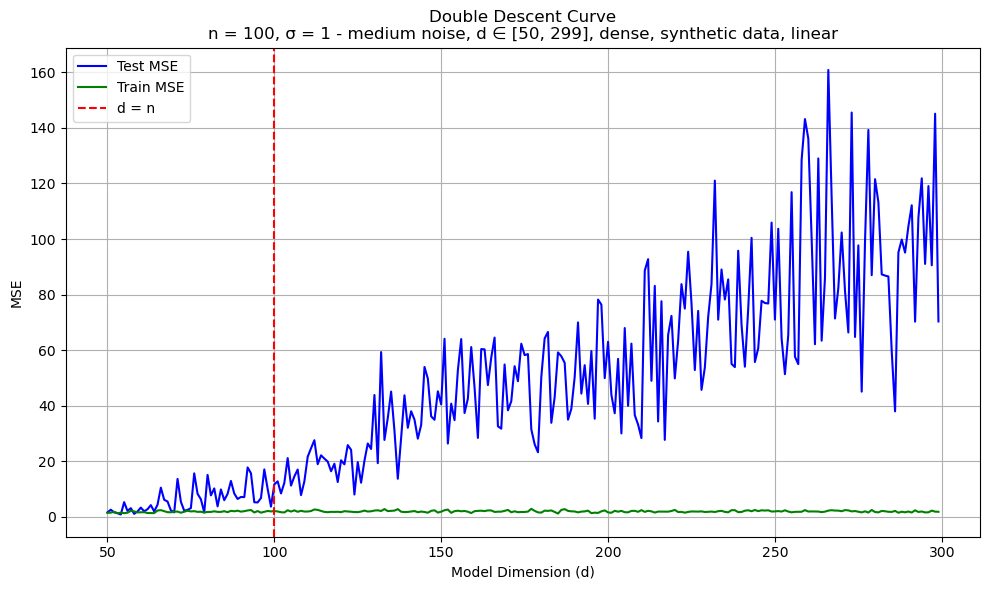

In [8]:


runExperiment(100, range(50,300), 1 , 1000, True, False, False)
